In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
import spectral
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import os

In [17]:
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc1 = nn.Conv2d(in_planes, in_planes // 16, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // 16, in_planes, 1, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)


# 空间注意力机制
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)


# 网络骨架
class HybridSN_PaviaU(nn.Module):
    def __init__(self, num_classes=9, self_attention=False):
        super(HybridSN_PaviaU, self).__init__()
        self.self_attention = self_attention

        # 3D卷积块
        self.block_1_3D = nn.Sequential(
            nn.Conv3d(
                in_channels=1,
                out_channels=8,
                kernel_size=(7, 3, 3),
                stride=1,
                padding=0
            ),
            nn.ReLU(inplace=True),
            nn.Conv3d(
                in_channels=8,
                out_channels=16,
                kernel_size=(5, 3, 3),
                stride=1,
                padding=0
            ),
            nn.ReLU(inplace=True),
            nn.Conv3d(
                in_channels=16,
                out_channels=32,
                kernel_size=(3, 3, 3),
                stride=1,
                padding=0
            ),
            nn.ReLU(inplace=True)
        )

        if self_attention:
            self.channel_attention_1 = ChannelAttention(256)
            self.spatial_attention_1 = SpatialAttention(kernel_size=7)

        # 2D卷积块
        self.block_2_2D = nn.Sequential(
            nn.Conv2d(
                in_channels=256,
                out_channels=64,
                kernel_size=(3, 3)
            ),
            nn.ReLU(inplace=True)
        )

        if self_attention:
            self.channel_attention_2 = ChannelAttention(64)
            self.spatial_attention_2 = SpatialAttention(kernel_size=7)

        # 全连接层
        self.classifier = nn.Sequential(
            nn.Linear(
                in_features=576,
                out_features=256
            ),
            nn.Dropout(p=0.4),
            nn.Linear(
                in_features=256,
                out_features=128
            ),
            nn.Dropout(p=0.4),
            nn.Linear(
                in_features=128,
                out_features=num_classes
            )
            # pytorch交叉熵损失函数是混合了softmax的。不需要再使用softmax
        )

    def forward(self, x):
        y = self.block_1_3D(x)
        y = y.view(-1, y.shape[1] * y.shape[2], y.shape[3], y.shape[4])

        if self.self_attention:
            y = self.channel_attention_1(y) * y
            y = self.spatial_attention_1(y) * y

        y = self.block_2_2D(y)
        if self.self_attention:
            y = self.channel_attention_2(y) * y
            y = self.spatial_attention_2(y) * y

        y = y.view(y.size(0), -1)

        y = self.classifier(y)
        return y

In [14]:
# 对高光谱数据 X 应用 PCA 变换
def applyPCA(X, numComponents):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0], X.shape[1], numComponents))
    return newX

# 对单个像素周围提取 patch 时，边缘像素就无法取了，因此，给这部分像素进行 padding 操作
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
#     newX=np.lib.pad(X,((margin,margin),(margin,margin),(0,0)),'reflect')
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

# 在每个像素周围提取 patch ，然后创建成符合 keras 处理的格式
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    # 给 X 做 padding
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState, stratify=y)
    return X_train, X_test, y_train, y_test

In [15]:
# 地物类别
class_num = 9

X = sio.loadmat('PaviaU.mat')['paviaU']
y = sio.loadmat('PaviaU_gt.mat')['paviaU_gt']

X = np.array(X).reshape(610, 340, 103)
y = np.array(y).reshape(610, 340)
# 用于测试样本的比例

# 每个像素周围提取 patch 的尺寸
patch_size = 11
# 使用 PCA 降维，得到主成分的数量
pca_components = 20


X_pca = applyPCA(X, numComponents=pca_components)

X_pca, y = createImageCubes(X_pca, y, windowSize=patch_size)


size = [0.50]
result = []
each_acc_result = []
for item in size:

    Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X_pca, y, item)


    # 改变 Xtrain, Ytrain 的形状，以符合 keras 的要求
    Xtrain = Xtrain.reshape(-1, patch_size, patch_size, pca_components, 1)
    Xtest = Xtest.reshape(-1, patch_size, patch_size, pca_components, 1)


    # 为了适应 pytorch 结构，数据要做 transpose
    Xtrain = Xtrain.transpose(0, 4, 3, 1, 2)
    Xtest = Xtest.transpose(0, 4, 3, 1, 2)

class TrainDS(torch.utils.data.Dataset):
    def __init__(self):
        self.len = Xtrain.shape[0]
        self.x_data = torch.FloatTensor(Xtrain)
        self.y_data = torch.LongTensor(ytrain)

    def __getitem__(self, index):
        # 根据索引返回数据和对应的标签
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        # 返回文件数据的数目
        return self.len


""" Testing dataset"""


class TestDS(torch.utils.data.Dataset):
    def __init__(self):
        self.len = Xtest.shape[0]
        self.x_data = torch.FloatTensor(Xtest)
        self.y_data = torch.LongTensor(ytest)

    def __getitem__(self, index):
        # 根据索引返回数据和对应的标签
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        # 返回文件数据的数目
        return self.len


# 创建 trainloader 和 testloader
trainset = TrainDS()
testset = TestDS()
train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=128, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(dataset=testset, batch_size=128, shuffle=False, num_workers=0)

In [18]:
# 使用GPU训练，可以在菜单 "代码执行工具" -> "更改运行时类型" 里进行设置
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
 
# 网络放到GPU上
net = HybridSN_PaviaU(self_attention=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
 
# 开始训练
total_loss = 0
for epoch in range(100):
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        # 优化器梯度归零
        optimizer.zero_grad()
        # 正向传播 +　反向传播 + 优化 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print('[Epoch: %d]   [loss avg: %.4f]   [current loss: %.4f]' %(epoch + 1, total_loss/(epoch+1), loss.item()))
 
print('Finished Training')

[Epoch: 1]   [loss avg: 123.4097]   [current loss: 0.2557]
[Epoch: 2]   [loss avg: 68.9414]   [current loss: 0.0066]
[Epoch: 3]   [loss avg: 48.3492]   [current loss: 0.0079]
[Epoch: 4]   [loss avg: 37.3860]   [current loss: 0.0002]
[Epoch: 5]   [loss avg: 30.3332]   [current loss: 0.0008]
[Epoch: 6]   [loss avg: 25.6864]   [current loss: 0.0002]
[Epoch: 7]   [loss avg: 22.2545]   [current loss: 0.0002]
[Epoch: 8]   [loss avg: 19.7528]   [current loss: 0.0008]
[Epoch: 9]   [loss avg: 17.6073]   [current loss: 0.0002]
[Epoch: 10]   [loss avg: 15.8796]   [current loss: 0.0000]
[Epoch: 11]   [loss avg: 14.6467]   [current loss: 0.0409]
[Epoch: 12]   [loss avg: 13.5328]   [current loss: 0.0000]
[Epoch: 13]   [loss avg: 12.5719]   [current loss: 0.0008]
[Epoch: 14]   [loss avg: 11.6949]   [current loss: 0.0000]
[Epoch: 15]   [loss avg: 10.9462]   [current loss: 0.0001]
[Epoch: 16]   [loss avg: 10.2928]   [current loss: 0.0000]
[Epoch: 17]   [loss avg: 9.6919]   [current loss: 0.0000]
[Epoch

... ... row  0  handling ... ...
... ... row  20  handling ... ...
... ... row  40  handling ... ...
... ... row  60  handling ... ...
... ... row  80  handling ... ...
... ... row  100  handling ... ...
... ... row  120  handling ... ...
... ... row  140  handling ... ...
... ... row  160  handling ... ...
... ... row  180  handling ... ...
... ... row  200  handling ... ...
... ... row  220  handling ... ...
... ... row  240  handling ... ...
... ... row  260  handling ... ...
... ... row  280  handling ... ...
... ... row  300  handling ... ...
... ... row  320  handling ... ...
... ... row  340  handling ... ...
... ... row  360  handling ... ...
... ... row  380  handling ... ...
... ... row  400  handling ... ...
... ... row  420  handling ... ...
... ... row  440  handling ... ...
... ... row  460  handling ... ...
... ... row  480  handling ... ...
... ... row  500  handling ... ...
... ... row  520  handling ... ...
... ... row  540  handling ... ...
... ... row  560  handling

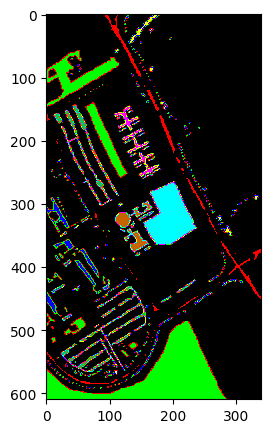

In [20]:
# load the original image
X = sio.loadmat(os.path.join('PaviaU.mat'))['paviaU']
y = sio.loadmat(os.path.join('PaviaU_gt.mat'))['paviaU_gt']
 
height = y.shape[0]
width = y.shape[1]
 
X = applyPCA(X, numComponents= pca_components)
X = padWithZeros(X, patch_size//2)
net.eval()
# 逐像素预测类别
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        if int(y[i,j]) == 0:
            continue
        else :
            image_patch = X[i:i+patch_size, j:j+patch_size, :]
            image_patch = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1)
            X_test_image = torch.FloatTensor(image_patch.transpose(0, 4, 3, 1, 2)).to(device)                                   
            prediction = net(X_test_image)
            prediction = np.argmax(prediction.detach().cpu().numpy(), axis=1)
            outputs[i][j] = prediction+1
    if i % 20 == 0:
        print('... ... row ', i, ' handling ... ...')
 
 
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(5,5))

In [ ]:
torch.save(model.state_dict(), "./PaviaU_model/PaviaU_parameter.pkl")

In [5]:
torch.save(net, os.path.join('PaviaU_model', 'PaviaU.pth')) # 保存模型结构和参数